In [1]:
import pandas as pd
import numpy as np
import json_module
import renderapi
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial
%matplotlib notebook
from render_module import RenderTrakEM2Parameters, TrakEM2RenderModule
import marshmallow as mm

parameters={
    "render":{
        "host":"ibs-forrestc-ux1",
        "port":8080,
        "owner":"Forrest",
        "project":"M247514_Rorb_1",
        "client_scripts":"/pipeline/render/render-ws-java-client/src/main/scripts"
    },
    "EMstack":"ALIGNEM_reg2",
    "trakem2project":"/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/m247514_Site3Annotation_cropedToMatch_MN.xml",
    "outputAnnotationFile":"/nas4/data/EM_annotation/annotationFilesForJHU/annotation_local.json",
    "renderHome":"/pipeline/render"
}

In [2]:
class ImportTrakEM2Annotations(RenderTrakEM2Parameters):
    EMstack = mm.fields.Str(required=True,metadata={'description':'stack to look for trakem2 patches in'})
    trakem2project = json_module.InputFile(required=True,metadata={'description':'trakem2 file to read in'})
    outputAnnotationFile = mm.fields.Str(required=True,metadata={'description':'name of stack to save annotation tilespecs'})


In [112]:
mod = TrakEM2RenderModule(args=[],
                          input_data = parameters,
                          schema_type = ImportTrakEM2Annotations,
                          )

ERROR:renderapi.render:Client functionality not implemented!


In [4]:
mod.run()
tem2file = mod.args['trakem2project']
trakem2dir = os.path.split(tem2file)[0]
jsonFileOut = os.path.join(trakem2dir,os.path.splitext(tem2file)[0]+'.json')

mod.convert_trakem2_project(tem2file,trakem2dir,jsonFileOut)


running! with args
{
    "log_level": "ERROR", 
    "EMstack": "ALIGNEM_reg2", 
    "render": {
        "project": "M247514_Rorb_1", 
        "owner": "Forrest", 
        "host": "ibs-forrestc-ux1", 
        "port": 8080, 
        "client_scripts": "/pipeline/render/render-ws-java-client/src/main/scripts"
    }, 
    "renderHome": "/pipeline/render", 
    "outputAnnotationStack": "Site3Annotation_MN", 
    "trakem2project": "/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/m247514_Site3Annotation_cropedToMatch_MN.xml"
}


In [35]:
tsjson = json.load(open(jsonFileOut,'r'))
tem2_tilespecs = [renderapi.tilespec.TileSpec(json=tsj) for tsj in tsjson]
render_tilespecs = []
for ts in tem2_tilespecs:
    pot_render_tilespecs = mod.render.run(renderapi.tilespec.get_tile_specs_from_z,
                                         mod.args['EMstack'],
                                         ts.z)
    filepath = os.path.split(ts.ip.get(0)['imageUrl'])[1]
    pot_filepaths = [os.path.split(t.ip.get(0)['imageUrl'])[1] for t in pot_render_tilespecs]
    render_tilespecs.append(next(t for t,fp in zip(pot_render_tilespecs,pot_filepaths) if fp==filepath))
    

In [6]:
import lxml.etree

In [7]:
root = lxml.etree.parse(open(tem2file,'r'))

In [8]:
area_lists=root.findall('//t2_area_list')
area_lists = [al for al in area_lists if (len(al.getchildren())>0)]
print len(area_lists)

1042


In [103]:
def convert_path(path,tform):
    d = path.attrib['d'].split(' ')
    Nelem = int(np.ceil(len(d)*1.0/3))
    points = np.zeros((Nelem,2))
    
    for k,i in enumerate(range(0,len(d)+1,3)):

        if d[i]=='M':
            points[k,:]=[float(d[i+1]),float(d[i+2])]
        elif d[i]=='L':
            points[k,:]=[float(d[i+1]),float(d[i+2])]
        elif d[i]=='z':
            points[k,:]=points[0,:]
    return tform.tform(points)
            
def convert_transform(tfs):
    tfs=tfs.replace('matrix(','')
    tfs=tfs.replace(')','')
    vals = tfs.split(',')
    tform = renderapi.transform.AffineModel(M00 = vals[0],
                                           M10 = vals[1],
                                           M01 = vals[2],
                                           M11 = vals[3],
                                           B0  = vals[4],
                                           B1  = vals[5])
    return tform

json_output = {'area_lists':[]}
for al in area_lists:
    areas = al.findall('t2_area')
    links=al.attrib['links']
    tform = convert_transform(al.attrib['transform'])
    area_list_d = dict(al.attrib)
    area_list_d['areas']=[]
    for area in areas:
        
        layerid=area.attrib['layer_id']
       
        area_d = dict(area.attrib)
        
        layer=root.find('//t2_layer[@oid="%s"]'%layerid)
        patches = [patch for patch in layer.getchildren() if patch.attrib['oid'] in links]
        patchids = [patch.attrib['oid'] for patch in patches]
        linked_tilespecs = [(ts,t) for ts,t in zip(tem2_tilespecs,render_tilespecs) if ts.tileId in patchids]
        
        paths = area.findall('t2_path')
        area_d['paths']=[]
        for path in paths:
            path_d = {}
            path_d['tile_paths']=[]
            path= convert_path(path,tform)
            path_d['orig_path']=path
            for ts,rts in linked_tilespecs:
                tile_path_d={}
                
                local_path = path
                tmp=list(ts.tforms)
                tmp.reverse()
                for t in tmp:
                    local_path = t.inverse_tform(local_path)
                tile_path_d['tileId']=rts.tileId
                tile_path_d['path']=local_path
                path_d['tile_paths'].append(tile_path_d)
                
            area_d['paths'].append(path_d)
            
        #for ts in linked_tilespecs:
        #    print ts.to_dict()
        area_list_d['areas'].append(area_d)
        
    json_output['area_lists'].append(area_list_d)
  

In [104]:
class NumpyArray(mm.fields.List):
    def _deserialize(self,value,attr,obj):
        mylist = super(NumpyArray,self)._serialize(value,attr,obj)
        return np.array(mylist)
    
    def _serialize(self,value,attr,obj):
        if value is None:
            return None
        return mm.fields.List._serialize(self,value.tolist(),attr,obj)
class TilePath(mm.Schema):
    tileId = mm.fields.Str()
    path = NumpyArray(mm.fields.List(mm.fields.Float))
class Path(mm.Schema):
    orig_path = NumpyArray(mm.fields.List(mm.fields.Float))
    tile_paths = mm.fields.Nested(TilePath)
class Area(mm.Schema):
    layer_id = mm.fields.Str()
    paths = mm.fields.Nested(Path,many=True)
class AreaList(mm.Schema):
    style = mm.fields.Str()
    locked = mm.fields.Boolean()
    links = mm.fields.Str()
    oid = mm.fields.Str()
    transform = mm.fields.Str()
    height = mm.fields.Float()
    weight = mm.fields.Float()
    fill_paint = mm.fields.Boolean()
    layer_set_id = mm.fields.Str()
    areas = mm.fields.Nested(Area,many=True)
class AnnotationFile(mm.Schema):
    area_lists = mm.fields.Nested(AreaList,many=True)

In [113]:
schema = AnnotationFile()
test = schema.dump(json_output)

In [117]:
json_output['area_lists'][0]

{'areas': [{'layer_id': '512', 'paths': [{'orig_path': array([[  11., -859.],
            [  11., -858.],
            [  10., -858.],
            [  10., -857.],
            [   9., -857.],
            [   9., -856.],
            [   7., -856.],
            [   7., -855.],
            [   6., -855.],
            [   6., -854.],
            [   4., -854.],
            [   4., -852.],
            [   2., -852.],
            [   2., -847.],
            [   1., -847.],
            [   1., -846.],
            [   0., -846.],
            [   0., -840.],
            [   0., -837.],
            [   0., -833.],
            [   0., -830.],
            [   1., -830.],
            [   1., -828.],
            [   3., -828.],
            [   3., -826.],
            [   4., -826.],
            [   4., -824.],
            [   5., -824.],
            [   5., -822.],
            [   6., -822.],
            [   6., -821.],
            [   7., -821.],
            [   7., -820.],
            [   8., -820.]

In [41]:
lxml.etree.tostring(al)

'<t2_area_list oid="559" width="769.0" height="1117.0" transform="matrix(1.0,0.0,0.0,1.0,-560.0,-934.0)" locked="true" title="area_list" links="298,309,320,331,342,353,364,375,485,496,507,518,521,529,540,551,647,939,2151" layer_set_id="3" fill_paint="true" style="stroke:none;fill-opacity:1.0;fill:#ff0000;">\n\t\t\t<t2_area layer_id="512">\n\t\t\t\t<t2_path d="M 571 75 L 571 76 L 570 76 L 570 77 L 569 77 L 569 78 L 567 78 L 567 79 L 566 79 L 566 80 L 564 80 L 564 82 L 562 82 L 562 87 L 561 87 L 561 88 L 560 88 L 560 94 L 560 97 L 560 101 L 560 104 L 561 104 L 561 106 L 563 106 L 563 108 L 564 108 L 564 110 L 565 110 L 565 112 L 566 112 L 566 113 L 567 113 L 567 114 L 568 114 L 568 115 L 569 115 L 569 118 L 571 118 L 571 120 L 572 120 L 572 121 L 573 121 L 573 122 L 574 122 L 574 124 L 575 124 L 575 126 L 577 126 L 577 128 L 580 128 L 580 132 L 581 132 L 581 134 L 582 134 L 582 135 L 583 135 L 583 136 L 584 136 L 584 137 L 585 137 L 585 138 L 585 140 L 586 140 L 586 141 L 587 141 L 587 1

In [14]:
print ts.ip.get(0)
print ts.z
render_tspecs=mod.render.run(renderapi.tilespec.get_tile_specs_from_z,
                             mod.args['EMstack'],
                             ts.z)


{'imageUrl': u'file:/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/Site 3/S_046_936280491/Tile_r2-c2_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas4/data/EM_annotation/annotationFilesForJHU/annotationTrakEMprojects_M247514_Rorb_1/trakem2.1474404253542.1123465259.478816230/trakem2.masks/41/9.518.zip'}
46.0


In [18]:
for ts in render_tspecs:
    print ts.ip.get(0)

{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c1_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c1_S_046_93628_mask.tif'}
{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r2-c2_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r2-c2_S_046_93628_mask.tif'}
{'imageUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c3_S_046_93628_flip.jpg', 'maskUrl': u'file:/nas/data/M247514_Rorb_1/EMraw/ribbon0000/M247514_Rorb_1_Ribbon0000_data/session_1836000179/Site%203/S_046_936280491/Tile_r1-c3_S_0

<IPython.core.display.Javascript object>


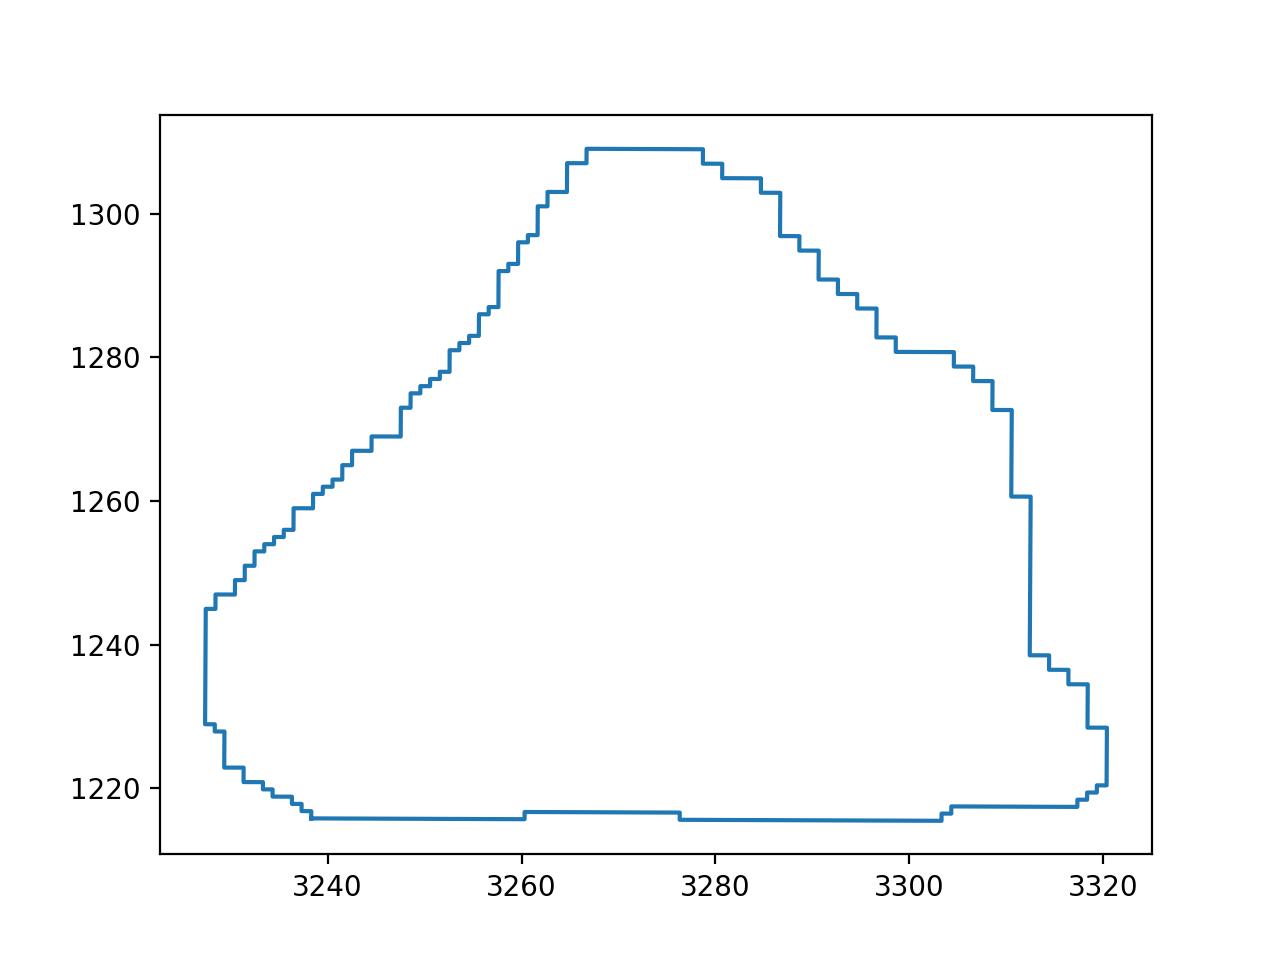

In [11]:
import matplotlib.pyplot as plt
plt.plot(local_path[:,0],local_path[:,1])


In [17]:
a=['a','b','c']
b=list(a)
a.reverse()
print a
print b

['c', 'b', 'a']
['a', 'b', 'c']


In [7]:
'ERROR' in 'ERROR IS HERE'

True

In [74]:
renderapi.tilespec.AffineModel.tform()

In [12]:
tform

M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-560.000000,-934.000000]

In [34]:
p2, Nd = tform.convert_to_point_vector(path)
pt = np.dot(np.linalg.inv(tile_tform.M), p2.T).T
print tform.convert_points_vector_to_array(pt, Nd)

[[ 3238.31965348  1215.78146328]
 [ 3238.32392414  1216.7859872 ]
 [ 3237.32418807  1216.79116012]
 [ 3237.32845874  1217.79568404]
 [ 3236.32872267  1217.80085697]
 [ 3236.33299333  1218.80538089]
 [ 3234.3335212   1218.81572673]
 [ 3234.33779186  1219.82025065]
 [ 3233.33805579  1219.82542358]
 [ 3233.34232645  1220.8299475 ]
 [ 3231.34285432  1220.84029335]
 [ 3231.35139564  1222.84934118]
 [ 3229.35192351  1222.85968703]
 [ 3229.37327682  1227.88230663]
 [ 3228.37354075  1227.88747955]
 [ 3228.37781141  1228.89200347]
 [ 3227.37807534  1228.8971764 ]
 [ 3227.40369931  1234.92431991]
 [ 3227.4165113   1237.93789167]
 [ 3227.43359395  1241.95598734]
 [ 3227.44640593  1244.9695591 ]
 [ 3228.446142    1244.96438617]
 [ 3228.45468333  1246.97343401]
 [ 3230.45415546  1246.96308816]
 [ 3230.46269679  1248.972136  ]
 [ 3231.46243285  1248.96696307]
 [ 3231.47097418  1250.97601091]
 [ 3232.47071024  1250.97083799]
 [ 3232.47925157  1252.97988582]
 [ 3233.47898764  1252.9747129 ]
 [ 3233.48

In [31]:
Nd

2

In [107]:
import tempfile